# 实验三：Softmax回归
姓名：王恩泰

学号：21114019

# 1. 自主实现Softmax

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## 1. 读取数据

In [3]:
# 训练集
mnist_train = torchvision.datasets.FashionMNIST(root='./Datasets', train=True,
                                                download=False, transform=transforms.ToTensor())
# 测试集
mnist_test = torchvision.datasets.FashionMNIST(root='./Datasets', train=False,
                                                download=False, transform=transforms.ToTensor())

# 通过DataLoader读取小批量数据样本
batch_size = 256
num_workers = 0
train_data = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True,
num_workers=num_workers)
test_data = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,
num_workers=num_workers)

## 2. 定义相关模型

In [ ]:
# Softmax公式：y_predict = softmax(w*x_train+b)
def softmax(x, w, b):
    # print(x)
    y = torch.mm(x.view((-1, num_input)),w)+b # 这里.view((-1, num_input)的作用？
    prob = (y.exp())/(y.exp().sum(dim=1, keepdim=True))
    # print(prob)
    return prob

# 梯度下降
def grad_descent(arg, lr, batch_size):
    for item in arg:
        item.data = item.data - lr * item.grad / batch_size

# 交叉熵 (参考PPT P55)
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1,y.view(-1,1)))

## 3. 初始化参数

In [ ]:
num_input = 28*28 # 每个样本的数据格式为28*28*1
num_output = 10 # label共10类

# w和b的初值
w = torch.tensor(np.random.normal(0,0.01,(num_input,num_output)), dtype=torch.float, requires_grad = True) # 均匀分布初值
# w = torch.tensor(np.ones((num_input,num_output)), dtype=torch.float, requires_grad = True)
b = torch.zeros(num_output, dtype=torch.float, requires_grad = True)
# print(w)
# print(b)
lr = 0.05 # 学习率
max_iter = 100
g_loss_list = []

## 4. 模型训练

iter: 0, loss = 54783.900993
iter: 1, loss = 38472.032970
iter: 2, loss = 34903.705154
iter: 3, loss = 32990.594078
iter: 4, loss = 31734.883720
iter: 5, loss = 30834.766045
iter: 6, loss = 30083.559048
iter: 7, loss = 29540.558315
iter: 8, loss = 29076.460476
iter: 9, loss = 28672.431492
iter: 10, loss = 28353.196312
iter: 11, loss = 28053.903145
iter: 12, loss = 27806.280281
iter: 13, loss = 27547.656452
iter: 14, loss = 27341.876465
iter: 15, loss = 27148.957104
iter: 16, loss = 27005.678635
iter: 17, loss = 26825.291344
iter: 18, loss = 26718.194614
iter: 19, loss = 26562.071972
iter: 20, loss = 26415.610115
iter: 21, loss = 26315.718567
iter: 22, loss = 26203.817135
iter: 23, loss = 26108.925617
iter: 24, loss = 25998.659794
iter: 25, loss = 25912.944992
iter: 26, loss = 25836.031277
iter: 27, loss = 25742.383591
iter: 28, loss = 25662.879963
iter: 29, loss = 25587.445690
iter: 30, loss = 25510.608013
iter: 31, loss = 25455.210968
iter: 32, loss = 25379.049065
iter: 33, loss = 253

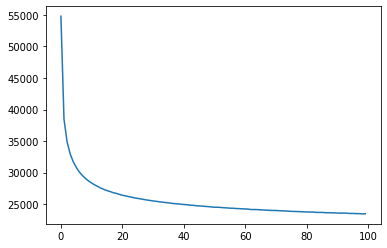

In [ ]:
for iter in range(max_iter):
    loss_sum = 0.0  
    for train_x, train_y in train_data:
        # print(train_x)
        # print(train_y)
        y_predict = softmax(train_x, w, b)
        loss_val = cross_entropy(y_predict, train_y).sum() # 交叉熵求loss
        loss_val.backward() # 反向计算各个参数梯度信息
        grad_descent([w,b], lr, batch_size) # 更新梯度：梯度下降
        # 梯度归零
        w.grad.data.zero_()
        b.grad.data.zero_()
        loss_sum = loss_sum + loss_val.item()
    # print('iter: %d, loss = %f' % (iter, loss_sum))
    g_loss_list.append(loss_sum)
plt.plot(g_loss_list)
plt.show()


## 5. 训练集准确率

In [ ]:
# train_accuracy
train_acc_val = 0.0
count = 0
for train_x, train_y in train_data:
    y_predict = softmax(train_x,w,b)
    train_acc_val += (y_predict.argmax(dim=1) == train_y).float().sum().item()
    count += y_predict.shape[0]
train_acc_val = train_acc_val/count
print('train accuracy = %f' % train_acc_val)

train accuracy = 0.865767


## 6. 测试集准确率

In [ ]:
# test_accuracy
test_acc_val = 0.0
count = 0
for test_x, test_y in test_data:
    y_predict = softmax(test_x,w,b)
    test_acc_val += (y_predict.argmax(dim=1) == test_y).float().sum().item()
    count += y_predict.shape[0]
test_acc_val = test_acc_val/count
print('test accuracy = %f' % test_acc_val)

test accuracy = 0.844200


# 二、利用torch.nn实现Softmax回归

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## 1. 构建Softmax模型

In [ ]:
class Softmax(nn.Module):
    def __init__(self, num_input, num_output):
        super(Softmax, self).__init__()
        self.linear = nn.Linear(num_input, num_output)
    def forward(self, x):
        y = self.linear(x.view(x.shape[0],-1)) # 重构维度:垂直尺寸，重构为1维？？
        return y

## 2. 初始化参数


In [ ]:
max_iter = 100

# 初始化一个softmax实例
softmax_model = Softmax(num_input, num_output)
loss_func = nn.CrossEntropyLoss() # 交叉熵loss
optimizer = optim.SGD(softmax_model.parameters(), lr = 0.05)

# 初始化w和b
torch.nn.init.normal_(softmax_model.linear.weight, mean=0, std=1)
torch.nn.init.constant_(softmax_model.linear.bias, val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 3. 训练模型

iter: 0, loss = 974.453311
iter: 1, loss = 544.852125
iter: 2, loss = 462.571397
iter: 3, loss = 416.313499
iter: 4, loss = 385.063765
iter: 5, loss = 361.601337
iter: 6, loss = 342.807378
iter: 7, loss = 327.768900
iter: 8, loss = 315.276645
iter: 9, loss = 303.479121
iter: 10, loss = 294.215829
iter: 11, loss = 285.604014
iter: 12, loss = 278.416330
iter: 13, loss = 271.320536
iter: 14, loss = 264.856448
iter: 15, loss = 259.681022
iter: 16, loss = 254.352366
iter: 17, loss = 249.351083
iter: 18, loss = 245.164234
iter: 19, loss = 240.709086
iter: 20, loss = 237.172134
iter: 21, loss = 233.363753
iter: 22, loss = 229.985659
iter: 23, loss = 226.868525
iter: 24, loss = 223.613782
iter: 25, loss = 220.528688
iter: 26, loss = 217.997491
iter: 27, loss = 215.671758
iter: 28, loss = 212.933601
iter: 29, loss = 210.601748
iter: 30, loss = 208.239649
iter: 31, loss = 206.216401
iter: 32, loss = 204.169047
iter: 33, loss = 202.271587
iter: 34, loss = 200.350988
iter: 35, loss = 198.432202
it

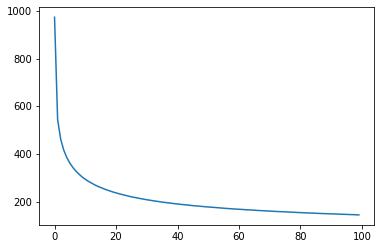

In [ ]:
g_loss_list = []
for iter in range(max_iter):
    loss_sum = 0
    for x_train,y_train in train_data:
        y_predict = softmax_model(x_train.view(-1, num_input))
        loss_value = loss_func(y_predict, y_train)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step() # 更新所有参数
        loss_sum += loss_value.item()
    # print('iter: %d, loss = %f' % (iter, loss_sum))
    g_loss_list.append(loss_sum)
plt.plot(g_loss_list)
plt.show()

## 4. 训练集准确率


In [ ]:
# train_accuracy
train_acc_val = 0.0
count = 0
for train_x, train_y in train_data:
    y_predict = softmax_model(train_x.view(-1, num_input))
    train_acc_val += (y_predict.argmax(dim=1) == train_y).float().sum().item()
    count += y_predict.shape[0]
train_acc_val = train_acc_val/count
print('train accuracy = %f' % train_acc_val)

train accuracy = 0.821767


## 5. 测试集准确率

In [ ]:
# test_accuracy
test_acc_val = 0.0
count = 0
for test_x, test_y in test_data:
    y_predict = softmax_model(test_x.view(-1, num_input))
    test_acc_val += (y_predict.argmax(dim=1) == test_y).float().sum().item()
    count += y_predict.shape[0]
test_acc_val = test_acc_val/count
print('test accuracy = %f' % test_acc_val)

test accuracy = 0.805400


In [ ]:
# demo_test for .view
# a=torch.Tensor([[[1,2,3],[4,5,6]]])
# a.view(a.shape[0],-1)
# print(a)